

<img src="https://digitaladvertisingmarketing.co.uk/wp-content/uploads/2020/06/Internet-News.jpg" width=1600 height=800 />

## Imported Libraries

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, os
from newspaper import Article
from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Web News URLs

In [46]:
health    = pd.read_csv('health.csv')
defense   = pd.read_csv('defense.csv')
economics = pd.read_csv('economics.csv')
dataset   = pd.concat([health, defense, economics])

In [47]:
dataset.head()

,url,type
0,https://www.medscape.com/viewarticle/963480,health
1,https://www.medscape.com/viewarticle/963473,health
2,https://www.medscape.com/viewarticle/963399,health
3,https://www.medscape.com/viewarticle/963373,health
4,https://www.medscape.com/viewarticle/963470,health


## The Web News Crawler

In [12]:
def scraperz(url):
    art = Article(url, language="en")
    art.download()
    art.parse()
    art.nlp()
    return art.text

In [14]:
dataset['text'] = dataset.url.apply(lambda x: scraperz(x))

In [16]:
dataset.to_csv('crawled_news.csv')

In [17]:
dataset['typeId'] = dataset['type'].factorize()[0]

In [18]:
dataset = dataset.drop(dataset.columns[0], axis = 1)

In [19]:
dataset.head()

,type,text,typeId
0,health,Veterans who have sustained a mild traumatic b...,0
1,health,Patients with giant cell arteritis (GCA) remai...,0
2,health,(Reuters) - Dangerous blood clots often seen i...,0
3,health,"SAN JOSE, Calif. (Reuters) - Prosecutors reste...",0
4,health,Women with a history of stage III to stage IV ...,0


In [20]:
target_category = dataset['type'].unique()
print(target_category)

['health' 'defense' 'economics']


In [21]:
dataset.groupby('type').typeId.count()

type
defense      66
economics    76
health       95
Name: typeId, dtype: int64

<AxesSubplot:xlabel='type'>

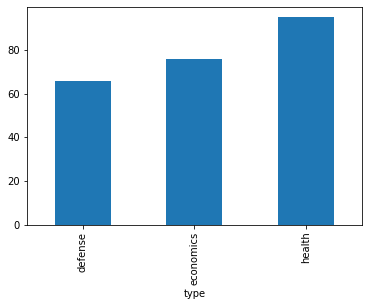

In [22]:
dataset.groupby('type').typeId.count().plot.bar(ylim=0)

## Pre-processing

In [23]:
def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
        
    #--Stemming--
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text

In [30]:
dataset['wordcount'] = dataset.text.apply(lambda x: len(x.split()))

In [31]:
dataset.head()

,type,text,typeId,wordcount
0,health,Veterans who have sustained a mild traumatic b...,0,1160
1,health,Patients with giant cell arteritis (GCA) remai...,0,704
2,health,(Reuters) - Dangerous blood clots often seen i...,0,166
3,health,"SAN JOSE, Calif. (Reuters) - Prosecutors reste...",0,225
4,health,Women with a history of stage III to stage IV ...,0,725


In [32]:
dataset.groupby('type').wordcount.sum()

type
defense      38053
economics    28660
health       66971
Name: wordcount, dtype: int64

<AxesSubplot:xlabel='type'>

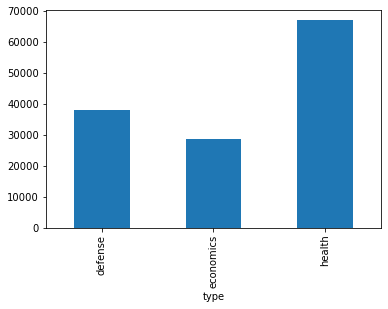

In [33]:
dataset.groupby('type').wordcount.sum().plot(kind = 'bar')

In [39]:
dataset.text = dataset.text.apply(preprocessDataset)
dataset.head()

,type,text,typeId,wordcount
0,health,veteran sustain mild traumat brain injuri mtbi...,0,1160
1,health,patient giant cell arter gca remain remiss lon...,0,704
2,health,reuter danger blood clot often see patient cov...,0,166
3,health,san jose calif reuter prosecutor rest crimin f...,0,225
4,health,woman histori stage iii stage iv breast cancer...,0,725


In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset.text, dataset.type, test_size = 0.3, random_state = 60,shuffle=True)

print(len(X_train))
print(len(X_test))

165
72


# Multinominal Naive Bayes


In [42]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,Y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Naive Bayes Train Accuracy Score : 100% 
Naive Bayes Test Accuracy Score  : 100% 

              precision    recall  f1-score   support

      health       1.00      1.00      1.00        22
     defense       1.00      1.00      1.00        21
   economics       1.00      1.00      1.00        29

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



# Decision Tree

In [43]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, Y_train)

test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 88% 

              precision    recall  f1-score   support

      health       0.91      0.91      0.91        22
     defense       0.95      0.80      0.87        25
   economics       0.79      0.92      0.85        25

    accuracy                           0.88        72
   macro avg       0.88      0.88      0.88        72
weighted avg       0.88      0.88      0.88        72



# Random Forest

In [45]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

rfc.fit(X_train, Y_train)

test_predict = rfc.predict(X_test)

train_accuracy = round(rfc.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Random Forest Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Random Forest Train Accuracy Score : 100% 
Random Forest Test Accuracy Score  : 99% 

              precision    recall  f1-score   support

      health       1.00      1.00      1.00        22
     defense       1.00      0.95      0.98        22
   economics       0.97      1.00      0.98        28

    accuracy                           0.99        72
   macro avg       0.99      0.98      0.99        72
weighted avg       0.99      0.99      0.99        72

